<a href="https://colab.research.google.com/github/MANIMALA-KOVURU/Demo-project/blob/main/ENERGY_MANAGMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import files
uploaded = files.upload()

Saving household_energy.csv to household_energy.csv


In [4]:
df = pd.read_csv("household_energy.csv", parse_dates=['timestamp'])
df.head()

,timestamp,temperature,outside_temperature,device_usage,energy_consumption
0,2025-07-01 00:00:00,23.75,39.26,0,2.95
1,2025-07-01 01:00:00,25.97,31.69,0,1.15
2,2025-07-01 02:00:00,28.66,34.02,1,3.21
3,2025-07-01 03:00:00,27.22,39.08,1,2.23
4,2025-07-01 04:00:00,23.04,32.87,1,2.34


In [5]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date

In [6]:
print("===basic info===")
print(df.info())

===basic info===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            50 non-null     datetime64[ns]
 1   temperature          50 non-null     float64       
 2   outside_temperature  50 non-null     float64       
 3   device_usage         50 non-null     int64         
 4   energy_consumption   50 non-null     float64       
 5   hour                 50 non-null     int32         
 6   day                  50 non-null     int32         
 7   weekday              50 non-null     int32         
 8   date                 50 non-null     object        
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(1)
memory usage: 3.1+ KB
None


In [7]:
print("\n=== Summary ===")
print(df.describe())


=== Summary ===
                           timestamp  temperature  outside_temperature  \
count                             50    50.000000             50.00000   
mean   2025-07-02 00:29:59.999999744    25.310800             32.44260   
min              2025-07-01 00:00:00    20.160000             25.10000   
25%              2025-07-01 12:15:00    22.792500             28.76500   
50%              2025-07-02 00:30:00    25.290000             31.99000   
75%              2025-07-02 12:45:00    27.500000             35.93500   
max              2025-07-03 01:00:00    29.770000             39.94000   
std                              NaN     2.809494              4.47634   

       device_usage  energy_consumption      hour        day    weekday  
count     50.000000           50.000000  50.00000  50.000000  50.000000  
mean       0.520000            2.944800  11.06000   1.560000   1.560000  
min        0.000000            1.150000   0.00000   1.000000   1.000000  
25%        0.000000 

In [9]:
daily_consumption = df.groupby('date')['energy_consumption'].sum()
weekly_consumption = df.groupby(df['timestamp'].dt.isocalendar().week)['energy_consumption'].sum()

In [10]:
print("\n=== Daily Consumption (First 5 Days) ===")
print(daily_consumption.head())


=== Daily Consumption (First 5 Days) ===
date
2025-07-01    67.46
2025-07-02    72.62
2025-07-03     7.16
Name: energy_consumption, dtype: float64


In [11]:
print("\n=== weekly Consumption (First 5 Days) ===")
print(weekly_consumption.head())


=== weekly Consumption (First 5 Days) ===
week
27    147.24
Name: energy_consumption, dtype: float64


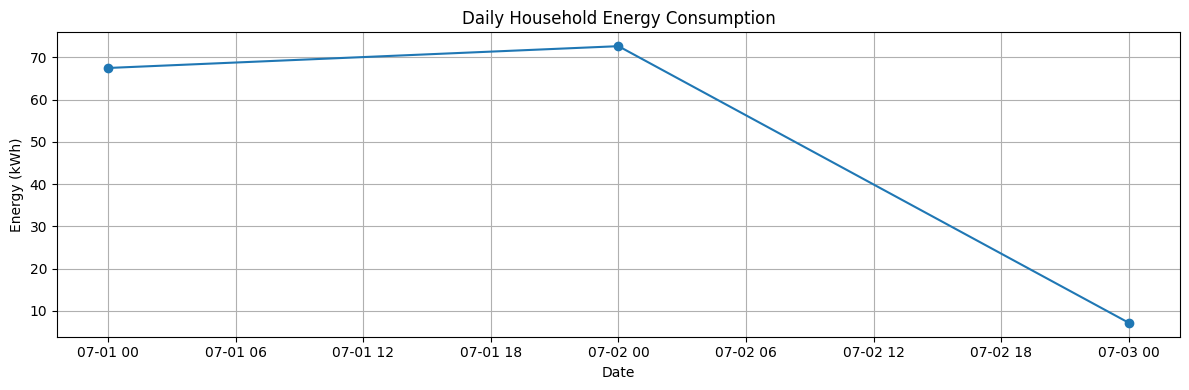

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(daily_consumption.index, daily_consumption.values, marker='o')
plt.title("Daily Household Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.tight_layout()
plt.savefig("daily_energy_plot.png")
plt.show()

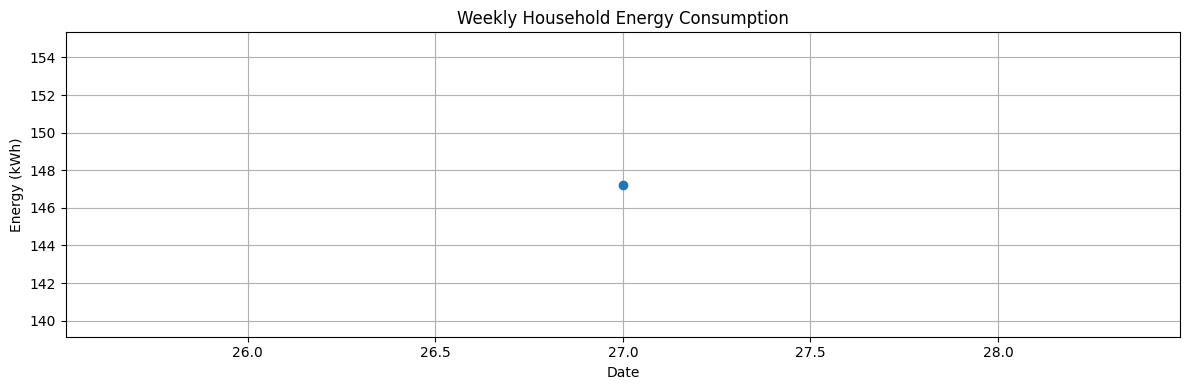

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(weekly_consumption.index, weekly_consumption.values, marker='o')
plt.title("Weekly Household Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.tight_layout()
plt.savefig("weekly_energy_plot.png")
plt.show()

In [14]:
features = [
    "temperature",           # fixed typo (was “temparature”)
    "outside_temperature",
    "device_usage",
    "hour",
    "weekday"
]
X = df[features]
y = df["energy_consumption"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LinearRegression()
model.fit(X_train, y_train)
joblib.dump(model, "forest_model.pkl")
print("Model saved as 'forest_model.pkl'")

Model saved as 'forest_model.pkl'


In [19]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nForecasting RMSE: {rmse:.3f}")


Forecasting RMSE: 0.700


In [18]:
df['moving_avg'] = df['energy_consumption'].rolling(window=6, min_periods=1).mean()
df['inefficient'] = df['energy_consumption'] > 1.25 * df['moving_avg']

In [21]:
print("\n=== Inefficient Usage Entries ===")
ineff_df = df[df['inefficient']]
print(ineff_df[['timestamp', 'energy_consumption', 'moving_avg']].head())


=== Inefficient Usage Entries ===
             timestamp  energy_consumption  moving_avg
2  2025-07-01 02:00:00                3.21    2.436667
6  2025-07-01 06:00:00                3.46    2.581667
8  2025-07-01 08:00:00                3.49    2.675000
12 2025-07-01 12:00:00                3.88    2.911667
19 2025-07-01 19:00:00                4.59    2.880000


In [22]:
recommendations = []

for _, row in ineff_df.iterrows():
    if row['device_usage'] > 0 and row['energy_consumption'] > 3:
        recommendations.append("Consider turing off idle device during high-usage periods.")
    if row['outside_temperature'] > 30 and row['energy_consumption'] > 3:
        recommendations.append("High outside temp + high usage: Adjust thermosstat or close blinds.")
    if row['hour'] in [0, 1, 2, 3, 4] and row['energy_consumption'] > 2:
        recommendations.append("High energy use detected at night. Investigate appliance usage")

In [23]:
recommendations = list(set(recommendations))
print("\n=== Recommendations===")
for rec in recommendations:
  print(f"- {rec}")


=== Recommendations===
- Consider turing off idle device during high-usage periods.
- High outside temp + high usage: Adjust thermosstat or close blinds.
- High energy use detected at night. Investigate appliance usage
